# Interactive Analytics

In this notebook you will answer 2 basic analytical questions about the data and visualise the result 

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, window, count, unix_timestamp, when, lit, ceil

import os
import matplotlib.pyplot as plt

In [28]:
spark = (
    SparkSession
    .builder
    .appName('Interactive Analytics I')
    .getOrCreate()
)

In [29]:
base_path = os.getcwd()

project_path = ('/').join(base_path.split('/')[0:-3]) 

answers_input_path = os.path.join(project_path, 'data/answers')

questions_input_path = os.path.join(project_path, 'output/questions-transformed')

# Task I

* Find out how many answers are being produced per week
* Plot the time evolution: on the x axis have date dimmension, on the y axis have number of answers per week

In [30]:
answersDF = (
    spark
    .read
    .option('path', answers_input_path)
    .load()
)

In [31]:
answersDF.show(truncate=25, n=5)

+---------+-----------------------+-------------------------+--------+-------+-----+-----------+
|answer_id|          creation_date|                     body|comments|user_id|score|question_id|
+---------+-----------------------+-------------------------+--------+-------+-----+-----------+
|   438044|2018-10-31 14:32:21.393|<p>It's my understandi...|       0| 211169|    1|     437989|
|   370391| 2017-11-23 06:13:42.58|<p>The charge distribu...|       2| 137842|    1|     370385|
|   427709| 2018-09-09 19:26:29.26|<p>The second law of t...|       3| 204101|    0|     427703|
|     5250|2011-02-16 04:07:12.207|<p>The only possible r...|       2|   null|    2|       5243|
|    39329|2012-10-08 06:08:40.623|<p>Briefly skimming th...|       0|   null|    4|      39117|
+---------+-----------------------+-------------------------+--------+-------+-----+-----------+
only showing top 5 rows



<b>Group the data</b>

Hint:
* use groupBy(window)

In [32]:
groupedDF = (
    answersDF
    .filter(col('user_id').isNotNull())
    .groupBy(
        window('creation_date', "1 week")
    )
    .agg(
        count('*').alias('answers')
    )
    .withColumn('date', col('window.start').cast('date'))
    .orderBy('window')
)

In [33]:
groupedDF.show(truncate=False, n=5)

+------------------------------------------+-------+----------+
|window                                    |answers|date      |
+------------------------------------------+-------+----------+
|[2010-08-19 02:00:00, 2010-08-26 02:00:00]|1      |2010-08-19|
|[2010-10-28 02:00:00, 2010-11-04 01:00:00]|112    |2010-10-28|
|[2010-11-04 01:00:00, 2010-11-11 01:00:00]|236    |2010-11-04|
|[2010-11-11 01:00:00, 2010-11-18 01:00:00]|335    |2010-11-11|
|[2010-11-18 01:00:00, 2010-11-25 01:00:00]|156    |2010-11-18|
+------------------------------------------+-------+----------+
only showing top 5 rows



In [34]:
groupedDF.count()

424

<b>Visualise the data:</b>

Hint
* convert the aggregated data to Pandas dataframe using toPandas()
* use ploting options of Pandas dataframe

In [35]:
local_data = groupedDF.toPandas()

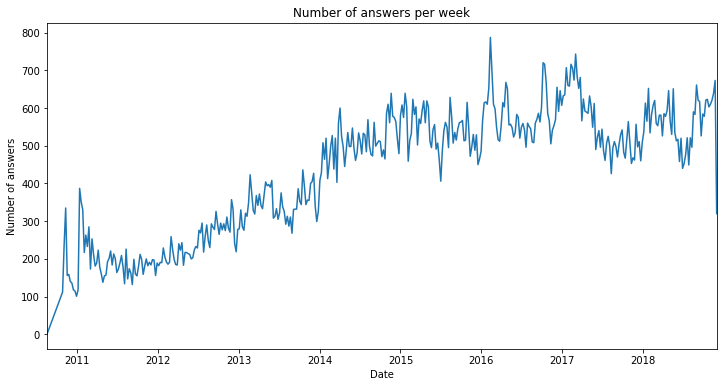

In [46]:
local_data.plot(
    x='date', y='answers', figsize=(12, 6), 
    title='Number of answers per week',
    legend=False
    
)
plt.xlabel('Date')
plt.ylabel('Number of answers')
plt.show()

# Task II

* Compute the response time
 * for each question compute the time it took to have accepted answer
 * consider only questions with accepted answer
* Plot number of answered questions as a function of response time
 * choose hour as time unit
 * create a bar chart (too see how many questions were answered within one hour, within 2 hours and so on)
 * chreta a cumulative sum

In [37]:
questionsDF = (
    spark
    .read
    .option('path', questions_input_path)
    .load()
)

<b>Compute response time:</b>

Hint:
* join questions with answers
* use unix_timestamp to compare the times
* convert to hours
* ceil the numbers

In [38]:
hourly_data = (
    questionsDF.alias('questions')
    .join(answersDF.alias('answers'), questionsDF['accepted_answer_id'] == answersDF['answer_id'])
    .select(
        col('questions.tags'),
        col('questions.creation_date').alias('question_time'),
        col('questions.title'),
        col('answers.creation_date').alias('answer_time')
    )
    .withColumn('response_time', unix_timestamp('answer_time') - unix_timestamp('question_time'))
    .filter(col('response_time') > 0)
    .withColumn('hours', ceil(col('response_time') / 3600))
)

<b>Aggregate the data and visualise</b>

Hint:
* group by hour
* count
* convert to Pandas
* visualize (take first 50 records)

In [39]:
hourly_data_grouped = (
    hourly_data
    .groupBy('hours')
    .agg(count('*').alias('cnt'))
    .orderBy('hours')
)

In [40]:
hourly_data_local = hourly_data_grouped.toPandas()

In [41]:
hourly_data_local.head(5)

,hours,cnt
0,1,21226
1,2,8317
2,3,4197
3,4,2705
4,5,1831


For bar chart you can use df.plot.bar

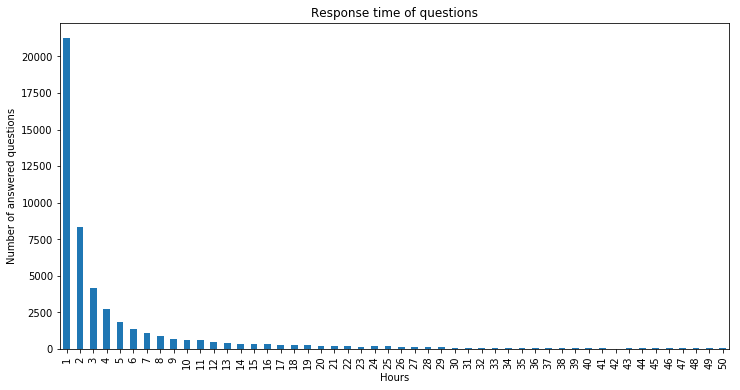

In [45]:
hourly_data_local.head(50).plot.bar(
    x='hours', y='cnt', figsize=(12, 6), 
    title='Response time of questions',
    legend=False
    
)
plt.xlabel('Hours')
plt.ylabel('Number of answered questions')
plt.show()

For cumulative sum you can use df['col'].comsum().plot()

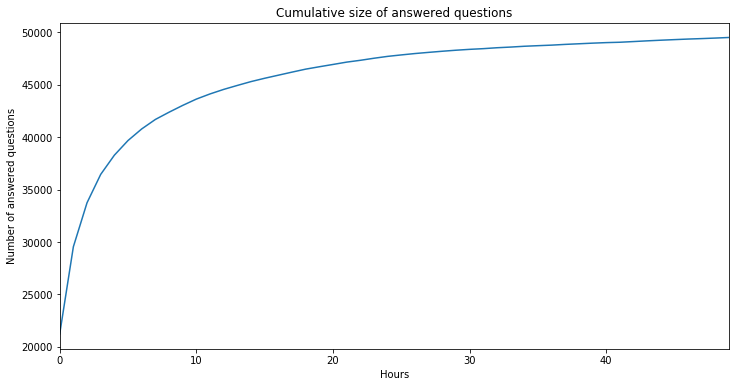

In [49]:
hourly_data_local.head(50)['cnt'].cumsum().plot(
    figsize=(12, 6),
    title='Cumulative size of answered questions'
)
plt.xlabel('Hours')
plt.ylabel('Number of answered questions')
plt.show()

In [ ]:
spark.stop()